In [1]:
import os
import sys
import time
import warnings
warnings.filterwarnings('ignore')
# libraries for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="white")
import pandas as pd
pd.set_option("display.max_columns", 30)
import numpy as np
from datetime import datetime
# Using make_column_transformer to One-Hot Encode
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from prince import mca

In [2]:
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
os.chdir(directory_path)
os.getcwd()

'/Users/iairlinker/Documents/repos/flight_delays_challenge'

In [3]:
start_notebook = time.time()

In [4]:
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

In [5]:
# Loading the joined dataset between flights and Airport database
path = os.getcwd() + '/data/processed/database.csv'
df = pd.read_csv(path, sep=',')
df.drop(columns=['Fecha-O','Fecha-I','AÑO','Des-I','Vlo-I','Vlo-O','Ori-O','Ori-I','IATA Code','Airport Name',
                 'Country','City/Town','ICAO Code','SIGLADES','SIGLAORI','Lat','Long','distance_to_destiny',
                 'OPERA','Emp-I','dif_min','temporada_alta'],inplace=True)
print(df.shape)
df.head(2)

(68206, 8)


,Des-O,Emp-O,DIA,MES,DIANOM,TIPOVUELO,atraso_15,periodo_dia
0,KMIA,AAL,1,1,Domingo,I,0,night
1,KMIA,AAL,2,1,Lunes,I,0,night


In [6]:
get_na(df)

,datos sin NAs en q,Na en q,Na en %
Des-O,68206,0,0.0
Emp-O,68206,0,0.0
DIA,68206,0,0.0
MES,68206,0,0.0
DIANOM,68206,0,0.0
TIPOVUELO,68206,0,0.0
atraso_15,68206,0,0.0
periodo_dia,68206,0,0.0


In [7]:
transformer = make_column_transformer(
    (OneHotEncoder(drop='first',sparse=False), ['Des-O','Emp-O','TIPOVUELO','periodo_dia','DIANOM','MES','DIA']),
    remainder='passthrough')

transformed = transformer.fit_transform(df)
transformed_df = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)
transformed_df.head()

,onehotencoder__x0_EGLL,onehotencoder__x0_EGYP,onehotencoder__x0_KATL,onehotencoder__x0_KDFW,onehotencoder__x0_KIAD,onehotencoder__x0_KIAH,onehotencoder__x0_KJFK,onehotencoder__x0_KLAX,onehotencoder__x0_KMCO,onehotencoder__x0_KMIA,onehotencoder__x0_LEMD,onehotencoder__x0_LFPG,onehotencoder__x0_LIRF,onehotencoder__x0_MDPC,onehotencoder__x0_MMMX,...,onehotencoder__x6_18,onehotencoder__x6_19,onehotencoder__x6_20,onehotencoder__x6_21,onehotencoder__x6_22,onehotencoder__x6_23,onehotencoder__x6_24,onehotencoder__x6_25,onehotencoder__x6_26,onehotencoder__x6_27,onehotencoder__x6_28,onehotencoder__x6_29,onehotencoder__x6_30,onehotencoder__x6_31,atraso_15
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
path = os.getcwd() + '/data/interim/model_data.csv' 
transformed_df.to_csv(path,
          sep=',',
          index = False
         )

In [9]:
df.drop('atraso_15', axis=1, inplace=True)
transformed_df.drop('atraso_15', axis=1, inplace=True)

In [10]:
results = []
n = []
for n_comp in range(0,100):
    model = mca.MCA(
        n_components=n_comp,
        n_iter=100,
        copy=True,
        check_input=True,
        engine='auto',
        random_state=42
    )
    mca_data = model.fit(df)
    mca_x = mca_data.transform(df)
    results.append(model.total_inertia_)
    n.append(n_comp)

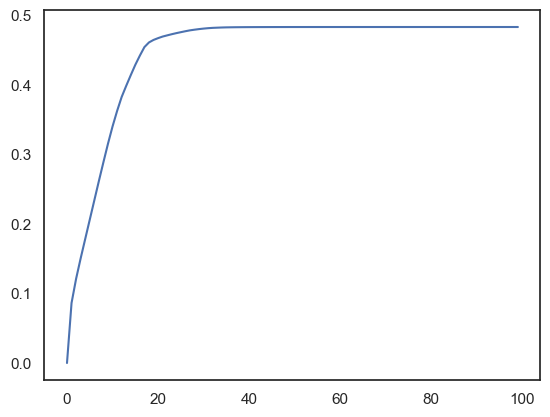

In [11]:
plt.plot(n,results);

In [12]:
model = mca.MCA(
    n_components=20,
    n_iter=100,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)

In [13]:
mca_data = model.fit(df)
mca_x = mca_data.transform(df)

In [14]:
path = os.getcwd() + '/data/interim/model_data_mca.csv' 
mca_x.to_csv(path,
          sep=',',
          index = False
         )